---
skip_showdoc: true
---

# Part 2: Aggregation via Fishnet

This script is the first in a two-step raster processing process. In this script a grid-based polygon will be derived from the raster grid of ERA5 data. The goal
is to create a fishnet that can be used to extract ERA5 data from raster stack including ERA5 hourly data (this file). This will allow for extraction from raster stack 
without the large computational burden of a loop (as below)

In [ ]:
import geopandas as gpd
import os 
import glob
# xarray makes working with labelled multi-dimensional arrays in Python simple, efficient, and fun!
import xarray
# The rioxarray package is an extension of xarray designed
# for working with raster (geospatial) data in Python. 
# It provides an easy way to read, write, and manipulate GeoTIFF and other raster formats while maintaining spatial metadata.
import rioxarray
# for geometric operations on vector data (points, lines, polygons). It allows users to create, manipulate, and analyze geometric shapes in 2D space
import shapely
from shapely.geometry import Polygon
import numpy
# you need to install gdal here, not osgeo
# gdal is generally a translator library for raster and vector geospatial data formats
from osgeo import gdal, ogr

In [ ]:
# create a fishnet grid using GDAL
def make_fishnet(outputGridfn,xmin,xmax,ymin,ymax,rows,cols):
    # Calculate grid parameters
    xmin = float(xmin)
    xmax = float(xmax)
    ymin = float(ymin)
    ymax = float(ymax)
    gridWidth = float((xmax-xmin) / cols)
    gridHeight = float((ymax-ymin) / rows)

    # Start grid cell envelope
    ringXleftOrigin = xmin
    ringXrightOrigin = xmin + gridWidth
    ringYtopOrigin = ymax
    ringYbottomOrigin = ymax-gridHeight

    # Create the output shapefile
    outDriver = ogr.GetDriverByName('ESRI Shapefile')
    if os.path.exists(outputGridfn):
        os.remove(outputGridfn)
    outDataSource = outDriver.CreateDataSource(outputGridfn)
    outLayer = outDataSource.CreateLayer(outputGridfn, geom_type=ogr.wkbPolygon)
    # Add fields to the layer
    featureDefn = outLayer.GetLayerDefn()

    # Create grid cells
    countcols = 0
    while countcols < cols:
        countcols += 1

        # Reset envelope for rows
        ringYtop = ringYtopOrigin
        ringYbottom =ringYbottomOrigin
        countrows = 0

        while countrows < rows:
            countrows += 1
            ring = ogr.Geometry(ogr.wkbLinearRing)
            ring.AddPoint(ringXleftOrigin, ringYtop)
            ring.AddPoint(ringXrightOrigin, ringYtop)
            ring.AddPoint(ringXrightOrigin, ringYbottom)
            ring.AddPoint(ringXleftOrigin, ringYbottom)
            ring.AddPoint(ringXleftOrigin, ringYtop)
            poly = ogr.Geometry(ogr.wkbPolygon)
            poly.AddGeometry(ring)

            # Add new geom to layer
            outFeature = ogr.Feature(featureDefn)
            outFeature.SetGeometry(poly)
            outLayer.CreateFeature(outFeature)
            outFeature = None

            # New envelope for next poly
            ringYtop = ringYtop - gridHeight
            ringYbottom = ringYbottom - gridHeight

        # New envelope for next poly
        ringXleftOrigin = ringXleftOrigin + gridWidth
        ringXrightOrigin = ringXrightOrigin + gridWidth

    # Save and close DataSources
    outDataSource = None

In [ ]:
from pyprojroot import here

In [ ]:
era_dir = here("data/ERA5_out")

In [ ]:
temp_file = xarray.open_dataset(os.path.join(era_dir, "2000_01.nc"), decode_coords="all")

In [ ]:
t0='2000-01-01T00:00:00.000000000'
temp_file['t2m']['valid_time'][0]


<xarray.DataArray 'valid_time' (valid_time: 744)> Size: 6kB
array(['2000-01-01T00:00:00.000000000', '2000-01-01T01:00:00.000000000',
       '2000-01-01T02:00:00.000000000', ..., '2000-01-31T21:00:00.000000000',
       '2000-01-31T22:00:00.000000000', '2000-01-31T23:00:00.000000000'],
      shape=(744,), dtype='datetime64[ns]')
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-01-01 ... 2000-01-31T23:...
    expver      (valid_time) <U4 12kB ...
Attributes:
    long_name:      time
    standard_name:  time

In [ ]:
list(temp_file['t2m']['valid_time'].data)

[np.datetime64('2000-01-01T00:00:00.000000000'),
 np.datetime64('2000-01-01T01:00:00.000000000'),
 np.datetime64('2000-01-01T02:00:00.000000000'),
 np.datetime64('2000-01-01T03:00:00.000000000'),
 np.datetime64('2000-01-01T04:00:00.000000000'),
 np.datetime64('2000-01-01T05:00:00.000000000'),
 np.datetime64('2000-01-01T06:00:00.000000000'),
 np.datetime64('2000-01-01T07:00:00.000000000'),
 np.datetime64('2000-01-01T08:00:00.000000000'),
 np.datetime64('2000-01-01T09:00:00.000000000'),
 np.datetime64('2000-01-01T10:00:00.000000000'),
 np.datetime64('2000-01-01T11:00:00.000000000'),
 np.datetime64('2000-01-01T12:00:00.000000000'),
 np.datetime64('2000-01-01T13:00:00.000000000'),
 np.datetime64('2000-01-01T14:00:00.000000000'),
 np.datetime64('2000-01-01T15:00:00.000000000'),
 np.datetime64('2000-01-01T16:00:00.000000000'),
 np.datetime64('2000-01-01T17:00:00.000000000'),
 np.datetime64('2000-01-01T18:00:00.000000000'),
 np.datetime64('2000-01-01T19:00:00.000000000'),
 np.datetime64('2000

In [ ]:
temp_file['t2m'][0].shape

(83, 101)

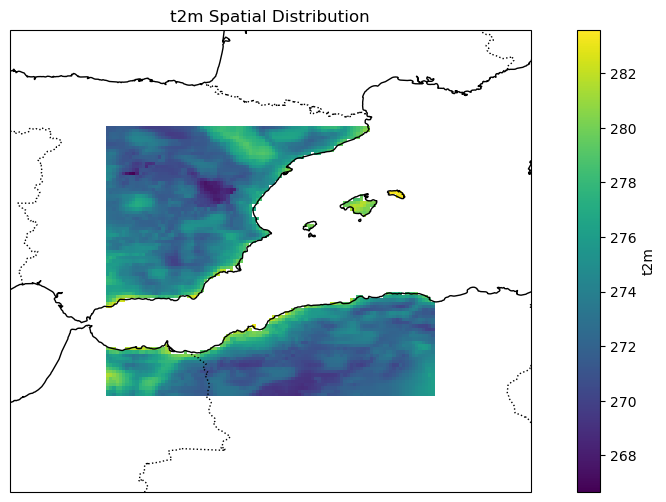

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#from matplotlib.pyplot 
import cartopy.feature as cfeature
import cartopy.crs as ccrs
# Ensure lat/lon are the correct names in your dataset

var=temp_file['t2m'][0]

lon = temp_file.coords.get("longitude")
lat = temp_file.coords.get("latitude")

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Set projection for geographic map

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

ax.set_extent([lon.min() - 3, lon.max() + 3, lat.min() - 3, lat.max() + 3], crs=ccrs.PlateCarree())

# Plot raster using lat/lon
im = ax.pcolormesh(lon, lat, var, transform=ccrs.PlateCarree())

# Add colorbar
plt.colorbar(im, label=var.name)
plt.title(f"{var.name} Spatial Distribution")

plt.show()

In [ ]:
lat

<xarray.DataArray 'latitude' (latitude: 83)> Size: 664B
array([42. , 41.9, 41.8, 41.7, 41.6, 41.5, 41.4, 41.3, 41.2, 41.1, 41. , 40.9,
       40.8, 40.7, 40.6, 40.5, 40.4, 40.3, 40.2, 40.1, 40. , 39.9, 39.8, 39.7,
       39.6, 39.5, 39.4, 39.3, 39.2, 39.1, 39. , 38.9, 38.8, 38.7, 38.6, 38.5,
       38.4, 38.3, 38.2, 38.1, 38. , 37.9, 37.8, 37.7, 37.6, 37.5, 37.4, 37.3,
       37.2, 37.1, 37. , 36.9, 36.8, 36.7, 36.6, 36.5, 36.4, 36.3, 36.2, 36.1,
       36. , 35.9, 35.8, 35.7, 35.6, 35.5, 35.4, 35.3, 35.2, 35.1, 35. , 34.9,
       34.8, 34.7, 34.6, 34.5, 34.4, 34.3, 34.2, 34.1, 34. , 33.9, 33.8])
Coordinates:
    number    int64 8B ...
  * latitude  (latitude) float64 664B 42.0 41.9 41.8 41.7 ... 34.0 33.9 33.8
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [ ]:
lon

<xarray.DataArray 'longitude' (longitude: 101)> Size: 808B
array([-4.800000e+00, -4.700000e+00, -4.600000e+00, -4.500000e+00,
       -4.400000e+00, -4.300000e+00, -4.200000e+00, -4.100000e+00,
       -4.000000e+00, -3.900000e+00, -3.800000e+00, -3.700000e+00,
       -3.600000e+00, -3.500000e+00, -3.400000e+00, -3.300000e+00,
       -3.200000e+00, -3.100000e+00, -3.000000e+00, -2.900000e+00,
       -2.800000e+00, -2.700000e+00, -2.600000e+00, -2.500000e+00,
       -2.400000e+00, -2.300000e+00, -2.200000e+00, -2.100000e+00,
       -2.000000e+00, -1.900000e+00, -1.800000e+00, -1.700000e+00,
       -1.600000e+00, -1.500000e+00, -1.400000e+00, -1.300000e+00,
       -1.200000e+00, -1.100000e+00, -1.000000e+00, -9.000000e-01,
       -8.000000e-01, -7.000000e-01, -6.000000e-01, -5.000000e-01,
       -4.000000e-01, -3.000000e-01, -2.000000e-01, -1.000000e-01,
       -1.387779e-16,  1.000000e-01,  2.000000e-01,  3.000000e-01,
        4.000000e-01,  5.000000e-01,  6.000000e-01,  7.000000e-01,
        8.000000e-01,  9.000000e-01,  1.000000e+00,  1.100000e+00,
        1.200000e+00,  1.300000e+00,  1.400000e+00,  1.500000e+00,
        1.600000e+00,  1.700000e+00,  1.800000e+00,  1.900000e+00,
        2.000000e+00,  2.100000e+00,  2.200000e+00,  2.300000e+00,
        2.400000e+00,  2.500000e+00,  2.600000e+00,  2.700000e+00,
        2.800000e+00,  2.900000e+00,  3.000000e+00,  3.100000e+00,
        3.200000e+00,  3.300000e+00,  3.400000e+00,  3.500000e+00,
        3.600000e+00,  3.700000e+00,  3.800000e+00,  3.900000e+00,
        4.000000e+00,  4.100000e+00,  4.200000e+00,  4.300000e+00,
        4.400000e+00,  4.500000e+00,  4.600000e+00,  4.700000e+00,
        4.800000e+00,  4.900000e+00,  5.000000e+00,  5.100000e+00,
        5.200000e+00])
Coordinates:
    number     int64 8B ...
  * longitude  (longitude) float64 808B -4.8 -4.7 -4.6 -4.5 ... 4.9 5.0 5.1 5.2
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude

In [ ]:
temp_file['t2m']

<xarray.DataArray 't2m' (valid_time: 744, latitude: 83, longitude: 101)> Size: 25MB
array([[[271.16016, 271.33008, ...,       nan,       nan],
        [271.31836, 271.4121 , ...,       nan,       nan],
        ...,
        [276.2871 , 275.96875, ..., 275.7871 , 275.95703],
        [275.98828, 275.44727, ..., 275.68555, 275.81445]],

       [[270.9795 , 271.2295 , ...,       nan,       nan],
        [271.27637, 271.5244 , ...,       nan,       nan],
        ...,
        [275.81934, 275.4756 , ..., 275.63184, 275.7881 ],
        [275.37012, 275.00488, ..., 275.48926, 275.59863]],

       ...,

       [[279.0088 , 279.13965, ...,       nan,       nan],
        [277.08887, 276.98145, ...,       nan,       nan],
        ...,
        [283.1338 , 282.36426, ..., 281.4795 , 281.65332],
        [281.50098, 281.4756 , ..., 281.64746, 281.73145]],

       [[275.7556 , 275.6599 , ...,       nan,       nan],
        [275.81226, 275.23218, ...,       nan,       nan],
        ...,
        [282.98218, 282.09155, ..., 280.3806 , 280.5935 ],
        [281.13452, 281.0564 , ..., 280.54468, 280.6931 ]]],
      shape=(744, 83, 101), dtype=float32)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-01-01 ... 2000-01-31T23:...
  * latitude    (latitude) float64 664B 42.0 41.9 41.8 41.7 ... 34.0 33.9 33.8
  * longitude   (longitude) float64 808B -4.8 -4.7 -4.6 -4.5 ... 4.9 5.0 5.1 5.2
    expver      (valid_time) <U4 12kB ...
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      8383
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [ ]:
era_files = glob.glob(os.path.join(era_dir, '*.nc'))

We read in the netcdf files and stack them in the 4th dimension by year

In [ ]:
era_stack = xarray.open_mfdataset(era_files, decode_coords="all")

In [ ]:
era_stack

<xarray.Dataset> Size: 5GB
Dimensions:     (valid_time: 50400, latitude: 83, longitude: 101)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 403kB 2000-01-01 ... 2005-09-30T2...
  * latitude    (latitude) float64 664B 42.0 41.9 41.8 41.7 ... 34.0 33.9 33.8
  * longitude   (longitude) float64 808B -4.8 -4.7 -4.6 -4.5 ... 4.9 5.0 5.1 5.2
    expver      (valid_time) <U4 806kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    d2m         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(372, 42, 51), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(372, 42, 51), meta=np.ndarray>
    skt         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(372, 42, 51), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-03T18:32 GRIB to CDM+CF via cfgrib-0.9.1...

The data above does not have a [coordinate reference system](https://en.wikipedia.org/wiki/Spatial_reference_system), needed to interpret, transform, or align datasets. Hence, we assign the WGS84 standard

In [ ]:
era_stack.rio.write_crs("WGS 84", inplace=True)

<xarray.Dataset> Size: 5GB
Dimensions:      (valid_time: 50400, latitude: 83, longitude: 101)
Coordinates:
    number       int64 8B 0
  * valid_time   (valid_time) datetime64[ns] 403kB 2000-01-01 ... 2005-09-30T...
  * latitude     (latitude) float64 664B 42.0 41.9 41.8 41.7 ... 34.0 33.9 33.8
  * longitude    (longitude) float64 808B -4.8 -4.7 -4.6 -4.5 ... 5.0 5.1 5.2
    expver       (valid_time) <U4 806kB dask.array<chunksize=(744,), meta=np.ndarray>
    spatial_ref  int64 8B 0
Data variables:
    d2m          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(372, 42, 51), meta=np.ndarray>
    t2m          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(372, 42, 51), meta=np.ndarray>
    skt          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(372, 42, 51), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-03T18:32 GRIB to CDM+CF via cfgrib-0.9.1...

Here, we are making a shapefile that is a fishnet grid of the raster extent.
It will essentially be a polygon of lines surrounding each ERA5 cell

In [ ]:
era_extent = era_stack.rio.bounds()

In [ ]:
xmin = era_extent[0]
xmax = era_extent[2]
ymin = era_extent[1]
ymax = era_extent[3]

height = era_stack.rio.height
width = era_stack.rio.width

era_coords = [(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)]
era_polygon = Polygon(era_coords)


In [ ]:
# implement the fishnet function
make_fishnet(os.path.join(era_dir, 'era_fishnet.shp'), xmin,xmax,ymin,ymax,height,width)


/Users/tit420/mamba/envs/era5_sandbox/lib/python3.13/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [ ]:
ogr_shp = gpd.read_file(os.path.join(era_dir, 'era_fishnet.shp'))
print(ogr_shp.crs) # this is none, so we have to set it

# Set the CRS for the created fishnet shape file as the same one from the stacked raster files. 
new_crs = era_stack.rio.crs.data  # Replace with the desired CRS
ogr_shp = ogr_shp.set_crs(new_crs)

None


In [ ]:
ogr_shp.to_file(os.path.join(era_dir, 'era_fishnet.shp'))